### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [2]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
import matplotlib.pyplot as plt
from qiskit import BasicAer, execute
import scipy as sc
#np.random.seed(16)

#example_matrix = np.array([[5.45, 11.14], [11.14, 1.42]])
#example_matrix = np.array([[18.45, 1.14], [1.14, 15.82]])
#example_matrix = np.array([[1.45, 5.14], [5.14, 7.82]])
#example_matrix = np.array([[13.45, 3.4], [3.4, 1.82]])
example_matrix=np.random.rand(2,2)

big_example_matrix = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 3]])
#example_matrix = np.array([[1.5, 0.5, 1.5, 0.4], [0.5, 2, 2.9, 1.5], [0.3,0.5, 2.5, 1.6], [0.5, 0.5, 0.5, 2.5]])
#example_matrix = np.array([[1.7, 0.2, 1.5, 0.2], [0.7, 1, 2.9, 1.1], [0.5,1.5, .7, 1.6], [0.5, 1.5, 0.5, 1.7]])
example_matrix=np.dot(example_matrix,example_matrix.T)
#example_matrix = np.array([[0.6407, 0.3288], [0.3288, 0.3593]])
#example_matrix = np.array([[1.5, 0.5], [0.5, 1.5]])

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.62188951 0.12972717 0.12972717 0.11865615]


In [3]:
eig,e_v=np.linalg.eig(example_matrix)
b=np.array([3.,2.])
#b=np.array([3.,2.,1.,0])
BB = e_v@np.diag(b)@e_v.T
BB, np.linalg.eig(BB)

(array([[2.76240878, 0.42560737],
        [0.42560737, 2.23759122]]),
 (array([3., 2.]),
  array([[ 0.87316023, -0.4874333 ],
         [ 0.4874333 ,  0.87316023]])))

In [4]:
example_matrix=BB

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.58699248 0.01393397 0.01393397 0.38513957]


In [29]:
example_matrix

array([[2.97768889, 0.14769334],
       [0.14769334, 2.02231111]])

In [5]:
np.linalg.eig(example_matrix)

(array([3., 2.]),
 array([[ 0.87316023, -0.4874333 ],
        [ 0.4874333 ,  0.87316023]]))

In [31]:
example_matrix1=example_matrix/np.trace(example_matrix)
example_matrix1,np.linalg.eig(example_matrix1)

(array([[0.59553778, 0.02953867],
        [0.02953867, 0.40446222]]),
 (array([0.6, 0.4]),
  array([[ 0.98878152, -0.14936903],
         [ 0.14936903,  0.98878152]])))

In [32]:
np.trace(example_matrix)*np.linalg.eig(example_matrix1)[0]

array([3., 2.])

as an example, whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

Note that the eigenvalues and the corresponding eigenvectors obtained by classical PCA are given by
$$\lambda_1=2, u_1=[1,1]^T$$
$$\lambda_2=1, u_2=[−1,1]^T.$$

Note: $[1, 0]^T = |0〉$ and $[0, 1]^T = |1〉.$ 

When we take a threshold τ=1.1 for eigenvalues, the eigenvalue in binary $|λ_1〉=|10〉$ and the corresponding eigenvector $|u_1〉=[1,1]^T=\frac{1}{\sqrt{2}}|0〉+\frac{1}{\sqrt{2}}|1〉$ are considered as principal components. Therefore, the output of the proposed algorithm should be given by

$$\begin{aligned}
\left|\psi_A^{\prime}\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle \\
&=|10\rangle \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \\
&=\frac{1}{2}|1000\rangle+\frac{1}{2}|1001\rangle+\frac{1}{2}|1010\rangle+\frac{1}{2}|1011\rangle .
\end{aligned}$$

In [6]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    print(general_bitstring,all_combinations)
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    thetas=[]
    
    '''for i in range(len(nodes)-len(input_probabilities)):
        print('i',i)
        right_node=i+idx_sub
        left_node=right_node+1
        #print(right_node,left_node)
        #print(left_node,right_node)
        if nodes[i]!=0:
            #print(nodes[right_node],nodes[i])
            thetas.append(2*np.arccos(nodes[right_node]/nodes[i]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[i]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx_sub+=1
    return thetas, all_combinations'''
    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [7]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))
    print(right_nodes_indexes,rotations_list)
    #qc=QuantumCircuit(len(example_matrix))
    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [8]:
thetas, all_combinations = thetas_computation(example_matrix)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw()

['00', '01', '10', '11'] ['0', '1', '00', '01', '10', '11']
0
[0, 1]
0 -> 0.7751944622778049
1
[2, 3]
1 -> 0.6317226809715043
00
[0]
00 -> 0.7661543465207182
01
[1]
01 -> 0.11804224520732459
10
[2]
10 -> 0.11804224520732459
11
[3]
11 -> 0.6205961440423545
[0, 2, 4] [('0', 1.3675469227133183), ('00', 0.30573813788554743), ('10', 2.7656676004089507)]


┌────────────┐┌───┐               ┌───┐              
q_0: ┤ Ry(1.3675) ├┤ X ├───────■───────┤ X ├──────■───────
     └────────────┘└───┘┌──────┴──────┐└───┘┌─────┴──────┐
q_1: ───────────────────┤ Ry(0.30574) ├─────┤ Ry(2.7657) ├
                        └─────────────┘     └────────────┘

In [9]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


{'00': 0.586992482692589,
 '01': 0.013933971653586,
 '10': 0.013933971653586,
 '11': 0.385139574000239}

In [10]:
#Unitary for PE
resolution = 2
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_1472/4115894098.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))


Operator([[-0.23759122-0.76240878j,  0.42560737-0.42560737j],
          [ 0.42560737-0.42560737j, -0.76240878-0.23759122j]],
         input_dims=(2,), output_dims=(2,))

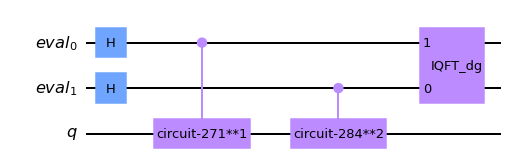

In [11]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

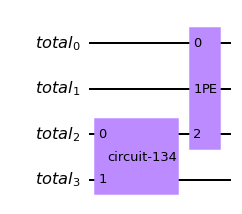

In [12]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
#total_circuit.p(np.pi,0)

#op=Operator(total_circuit)
#qc1.append(op.conjugate(),qr)

total_circuit.draw("mpl")

In [13]:
op_U=total_circuit.to_gate(label='op_U').control()

In [14]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [15]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [16]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix))))]
ss=attach_bitstrings(statevector)
ss

[('0000', (-0-0j)),
 ('0001', (0.1318-0j)),
 ('0010', -0j),
 ('0011', (0.6344+0j)),
 ('0100', (-0-0j)),
 ('0101', (-0.2361-0j)),
 ('0110', (-0-0j)),
 ('0111', (0.3541+0j)),
 ('1000', (-0-0j)),
 ('1001', (-0.2361-0j)),
 ('1010', (-0+0j)),
 ('1011', (0.3541+0j)),
 ('1100', (-0-0j)),
 ('1101', (0.4229+0j)),
 ('1110', -0j),
 ('1111', (0.1977+0j))]

# Computing Probabilities

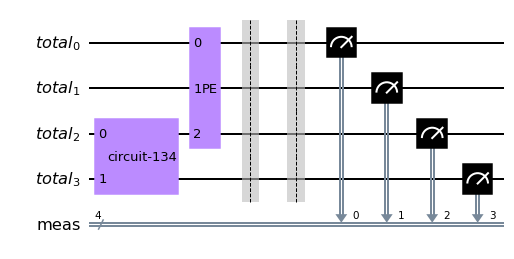

In [17]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()
total_circuit.barrier()

total_circuit.measure_all()
total_circuit.draw("mpl")

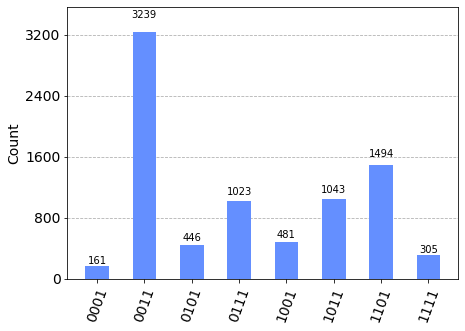

In [18]:
n_shots=8192
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

# Storing probabilities

In [19]:
for i in counts:
    counts[i]/=n_shots
counts

{'0001': 0.0196533203125,
 '0101': 0.054443359375,
 '1101': 0.182373046875,
 '1111': 0.0372314453125,
 '0111': 0.1248779296875,
 '0011': 0.3953857421875,
 '1011': 0.1273193359375,
 '1001': 0.0587158203125}

In [20]:

statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
statevector

array([0.        , 0.01965332, 0.        , 0.39538574, 0.        ,
       0.05444336, 0.        , 0.12487793, 0.        , 0.05871582,
       0.        , 0.12731934, 0.        , 0.18237305, 0.        ,
       0.03723145])

In [21]:
from qiskit.circuit.library.data_preparation.state_preparation import *
from qiskit.extensions import UnitaryGate
from qiskit.circuit.controlledgate import ControlledGate
op_V = StatePreparation(np.sqrt(statevector),label='c_V').control()

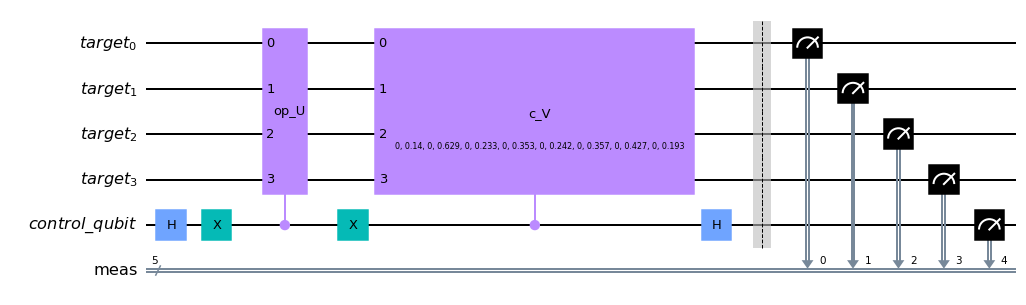

In [22]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'target')
#qr_total_pi = QuantumRegister(tot_qubit, 'pi')
qr_control = QuantumRegister(1, 'control_qubit')
#n_classical_register=tot_qubit+1
#classical = ClassicalRegister(n_classical_register, 'measure')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_control, name='matrix')
total_circuit_2.h(qr_control)
total_circuit_2.x(qr_control)
total_circuit_2.append(op_U, qr_control[:]+qr_total_xi[:])
total_circuit_2.x(qr_control)
total_circuit_2.append(op_V, qr_control[:]+qr_total_xi[:])
total_circuit_2.h(qr_control)
total_circuit_2.measure_all()
total_circuit_2.draw("mpl")

In [23]:

'''
tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'xi')
qr_total_pi = QuantumRegister(tot_qubit, 'pi')
qr_control = QuantumRegister(1, 'control_qubit')
n_classical_register=tot_qubit+1
classical = ClassicalRegister(n_classical_register, 'measure')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_total_pi,qr_control ,classical, name='matrix')

total_circuit_2.append(matrix_circuit.to_gate(), qr_total_xi[resolution:])
total_circuit_2.append(pe.to_gate(), qr_total_xi[0:pe.num_qubits])

#total_circuit_2.swap(qr_total_xi[0],qr_total_xi[1])
total_circuit_2.initialize(np.sqrt(statevector),qr_total_pi)
#total_circuit_2.append(op.conjugate(),qr_total_pi)
'''total_circuit_2.append(matrix_circuit.to_gate(), qr_total_pi[resolution:])
total_circuit_2.append(pe.to_gate(), qr_total_pi[0:pe.num_qubits])'''

total_circuit_2.h(qr_control)

for i in range(tot_qubit):
    total_circuit_2.cswap(control_qubit=qr_control, target_qubit1=qr_total_xi[i],target_qubit2=qr_total_pi[i])

total_circuit_2.h(qr_control)

total_circuit_2.measure(qr_total_xi,classical[0:n_classical_register-1])
total_circuit_2.measure(qr_control,classical[n_classical_register-1])

total_circuit_2.draw("mpl")
'''

SyntaxError: invalid syntax (3091030015.py, line 18)

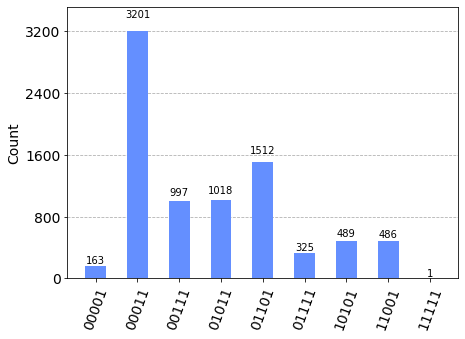

In [24]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [35]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
tmp

array([   0.,  203.,    0., 2953.,    0.,    0.,    0., 1148.,    0.,
          0.,    0., 1151.,    0., 1221.,    0.,  459.])

In [36]:
len(statevector),len(tmp)

(16, 16)

In [39]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=1
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [40]:
sign_dictionary

{'0000': 1,
 '0001': 1,
 '0010': 1,
 '0011': 1,
 '0100': 1,
 '0101': -1,
 '0110': 1,
 '0111': 1,
 '1000': 1,
 '1001': -1,
 '1010': 1,
 '1011': 1,
 '1100': 1,
 '1101': 1,
 '1110': 1,
 '1111': 1}

In [41]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

statevector_dictionary

{'0000': 0.0,
 '0001': 0.1660960283239789,
 '0010': 0.0,
 '0011': 0.5941610419322357,
 '0100': 0.0,
 '0101': -0.24926650208662213,
 '0110': 0.0,
 '0111': 0.37320534101550584,
 '1000': 0.0,
 '1001': -0.25555355052806444,
 '1010': 0.0,
 '1011': 0.3741853129633765,
 '1100': 0.0,
 '1101': 0.39697956299726567,
 '1110': 0.0,
 '1111': 0.23463527215126886}

In [42]:
ss

[('0000', 0j),
 ('0001', (0.1579+0j)),
 ('0010', (-0+0j)),
 ('0011', (0.5952-0j)),
 ('0100', 0j),
 ('0101', (-0.2503+0j)),
 ('0110', 0j),
 ('0111', (0.3755-0j)),
 ('1000', 0j),
 ('1001', (-0.2503+0j)),
 ('1010', 0j),
 ('1011', (0.3755-0j)),
 ('1100', 0j),
 ('1101', (0.3968-0j)),
 ('1110', (-0+0j)),
 ('1111', (0.2369-0j))]

# Eigenvectors reconstruction (2x2 matrix)


In [43]:
binary_lambda=[]
for d in statevector_dictionary:
    if statevector_dictionary[d]!=0:
        binary_lambda.append(d[-resolution:])
l_list=[]
eigenvalues=[]
for b_l in np.unique(binary_lambda):
    eigenvalues.append(int(b_l[::-1],2))
    tmp_list=[]
    for key in list(statevector_dictionary.keys()):
        if key[-resolution:]==b_l:
            tmp_list.append(statevector_dictionary[key])
    l_list.append(np.asarray(tmp_list))
l_list

[array([ 0.16609603, -0.2492665 , -0.25555355,  0.39697956]),
 array([0.59416104, 0.37320534, 0.37418531, 0.23463527])]

In [44]:
for l in l_list:
    normalization_factor=np.sqrt((1/(sum(l**2))))
    l*=normalization_factor

# Non eseguire le prossime celle-> si riferiscono ai conti fatti dopo

In [251]:
l_list

[array([ 0.02487923, -0.18736271,  0.01880693,  0.05719904, -0.10680283,
         0.909369  , -0.09862437, -0.31413765, -0.01628728,  0.08669566,
         0.        , -0.03118776,  0.        ,  0.06649254, -0.00940346,
        -0.02487923]),
 array([ 0.88370213,  0.07377497, -0.4228159 ,  0.03393155,  0.01772018,
         0.        ,  0.        ,  0.        ,  0.14395938,  0.01023075,
        -0.05877117, -0.01023075,  0.08681077,  0.        , -0.03688749,
        -0.01023075]),
 array([ 0.16746511, -0.07463575,  0.2775365 , -0.3508948 , -0.15862936,
         0.06789746, -0.29854301,  0.3754879 , -0.08081414,  0.04157853,
        -0.13148287,  0.16162829, -0.21336447,  0.11428846, -0.37497599,
         0.50544481]),
 array([0.10582468, 0.11233706, 0.25719353, 0.21691459, 0.1532455 ,
        0.16856757, 0.38357703, 0.33125843, 0.09255428, 0.09803553,
        0.22772225, 0.18934909, 0.1831797 , 0.20604706, 0.4646188 ,
        0.39553735])]

In [253]:
np.linalg.eig(example_matrix)

(array([3.00000000e+00, 2.00000000e+00, 1.00000000e+00, 1.38840214e-16]),
 array([[-0.27283206, -0.89909441,  0.32289714,  0.11370725],
        [-0.30415742, -0.07818057, -0.14423829, -0.93838765],
        [-0.69638872,  0.42791917,  0.56686168,  0.1029358 ],
        [-0.58999464, -0.04901247, -0.74404341,  0.30968291]]))

$$\left|11\right\rangle(0.1058|0000\rangle+0.1123|0001\rangle+0.2571|0010\rangle+0.2169|0011\rangle+
0.1532|0100\rangle+0.1685|0101\rangle+0.3835|0110\rangle+0.3312|0111\rangle+0.09255|1000\rangle+0.09803|1001\rangle+0.2277|1010\rangle+0.1893|1011\rangle+
0.1831|1100\rangle+0.2060|1101\rangle+0.4646|1110\rangle+0.3955|1111\rangle) =$$

$$\left|11\right\rangle\left[\textbf{0.2571|00}\rangle(0.41|00\rangle+0.43|01\rangle+|10\rangle+0.84|11\rangle)+\\
\textbf{0.3835|01}\rangle(0.399|00\rangle+0.48|01\rangle+|10\rangle+0.86|11\rangle)+\\
\textbf{0.2277|01}\rangle(0.40|00\rangle+0.43|01\rangle+|10\rangle+0.83|11\rangle)+\\
\textbf{0.4646|01}\rangle(0.39|00\rangle+0.44|01\rangle+|10\rangle+0.8|11\rangle)\right]\\
$$

$$\sqrt{0.4646}=0.68 -> 3 posizione 
\\
0.68*0.39=0.265-> 1 posizione
\\
0.68*0.44=0.29 -> 2 posizione
\\
0.68*0.8=0.54 -> 4 posizione
$$




$$\left|10\right\rangle(0.1674|0000\rangle-0.0746|0001\rangle+0.27753|0010\rangle-0.3508|0011\rangle-0.1586|0100\rangle+0.06789|0101\rangle-0.2985|0110\rangle+0.3754|0111\rangle-0.08081|1000\rangle+0.04157|1001\rangle-0.1314|1010\rangle+0.1616|1011\rangle-0.2133|1100\rangle+0.11428|1101\rangle-0.3749|1110\rangle+0.50544|1111\rangle) =$$


$$\left|10\right\rangle\left[\textbf{0.3508|00}\rangle(0.4771|00\rangle-0.2126|01\rangle+0.7911|10\rangle-|11\rangle)-\\
\textbf{0.3754|01}\rangle(0.4224|00\rangle-0.187|01\rangle+0.7951|10\rangle-|11\rangle)-\\
\textbf{0.1616|10}\rangle(0.50|00\rangle-0.26|01\rangle+0.8131|10\rangle-|11\rangle)-\\
\textbf{0.50544|10}\rangle(0.42|00\rangle-0.22|01\rangle+0.75|10\rangle-|11\rangle)\right]=
$$


$$
\sqrt{0.50544}=\approx0.71 -> 4 posizione 
\\
0.71*0.42=0.29-> 1 posizione
\\
0.68*0.22=0.15 -> 2 posizione
\\
0.68*0.75=... -> 3 posizione
$$

Magari possiamo fare una media dei vari rapporti. Per esempio: (0.4771+0.4224+0.50+0.42)/4=x. Dopodichè moltiplicare la radice del massimo dei massimi (0.71 in quest'ultimo caso) per x invece che per 0.42 per trovare il valore della prima posizione dell'eigenvector.

Prendiamo sempre il massimo dei massimi perchè è quello che viene influenzato meno da eventuali errori di approssimazione (?)





In [45]:
l_list

[array([ 0.29706359, -0.44581441, -0.45705883,  0.70999997]),
 array([0.7166488 , 0.45014254, 0.45132454, 0.28300591])]

In [51]:
np.linalg.eig(example_matrix),example_matrix

((array([3., 2.]),
  array([[ 0.84576432, -0.53355667],
         [ 0.53355667,  0.84576432]])),
 array([[2.71531728, 0.45126319],
        [0.45126319, 2.28468272]]))

In [50]:
np.sqrt(0.70999)*0.6437

0.5423874412291457

$$\left|10\right\rangle(0.29706|00\rangle-0.44581|01\rangle-0.45705|10\rangle+0.70999|11\rangle) =$$

$$\left|10\right\rangle(0.44581|0\rangle(0.66|0\rangle-|1\rangle)+0.70999|1\rangle(-0.6437|0\rangle+|1\rangle)) =$$

$$\sqrt{0.70999}=0.84260 -> posizione 1$$ 

$$0.7840*0.6437=0.5423 -> posizione 0$$




# Eigenvectors Reconstruction (Generalized)

In [194]:
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(l_list,eigenvalues):
    #print(ll,eig)
    eigenvector=np.zeros(len(example_matrix)) #put length of eigenvector
    save_sign=np.sign(ll)
    statevector=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(statevector),len(example_matrix))):
        max_list.append(max(statevector[i:i+len(example_matrix)]))
        scaled_statevectors.append(statevector[i:i+len(example_matrix)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvectors.append((eig,eigenvector))
    print(eigenvector)
    print('eigenvalue:', eig)
    

[0.70745204 0.71128881]
eigenvalue: 2
[ 0.71672949 -0.68571643]
eigenvalue: 1


In [195]:
np.linalg.eig(example_matrix)

(array([2., 1.]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

# Benchmarking 

In [328]:
import seaborn as sns
import statistics
def plot_confidence_interval(x, y, z=.96, color='#2187bb', horizontal_line_width=.0025):
    #mean = statistics.mean(values)
    #stdev = statistics.stdev(y)
    confidence_interval = z * y 

    left = x - horizontal_line_width / 7
    top = y - confidence_interval
    right = x + horizontal_line_width / 7
    bottom = y + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, y, 'o', color='#f44336')

    return y, confidence_interval


def eigenvectors_benchmarking(originals, reconstructed,delta,print_distances=True):
    idx=0
    for eig,eigenvector in sorted(eigenvectors,reverse=True):
        fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot

        for i in range(len(np.linalg.eig(originals)[1][:,idx])):
            circle=plt.Circle((i+1,abs(np.linalg.eig(originals)[1][:,idx])[i]),np.sqrt(7)*delta,color='g',alpha=0.1)
            ax.add_patch(circle)
            plt.hlines(abs(np.linalg.eig(originals)[1][:,idx])[i],xmin=i+1,xmax=i+1+(np.sqrt(7)*delta))
            plt.text(i+1+((i+1+(np.sqrt(7)*delta))-(i+1))/2,abs(np.linalg.eig(originals)[1][:,idx])[i]+0.01,r'$\delta$')

        plt.plot(list(range(1,len(originals)+1)),abs(eigenvector),marker='o',label='reconstructed',linestyle='None',markersize=12)
        plt.plot(list(range(1,len(originals)+1)),abs(np.linalg.eig(originals)[1][:,idx]),marker='o',label='original',linestyle='None',markersize=12)
        plt.plot([], [], ' ', label=r'$\delta$='+str(round(delta,4)))
        plt.legend()

        plt.ylabel("eigenvector's values")
        plt.title('Eigenvectors corresponding to eigenvalues '+str(eig))
        plt.show()
        idx+=1



0.9290286133398019

In [279]:
delta=np.sqrt((36*len(np.linalg.eig(example_matrix)[1][:,0])*np.log(len(np.linalg.eig(example_matrix)[1][:,0])))/(5000))
delta

0.09990655333892373

In [317]:

'''#circle2=plt.Circle((2,abs(np.linalg.eig(example_matrix)[1][:,0])[1]),0.5,color='g',alpha=0.1)

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot

for i in range(len(np.linalg.eig(example_matrix)[1][:,0])):
    print((i+1,abs(np.linalg.eig(example_matrix)[1][:,0])[i]))
    circle=plt.Circle((i+1,abs(np.linalg.eig(example_matrix)[1][:,0])[i]),delta,color='g',alpha=0.1)
    ax.add_patch(circle)
    plt.hlines(abs(np.linalg.eig(example_matrix)[1][:,0])[i],xmin=i+1,xmax=i+1+delta)
    plt.text(i+1+((i+1+delta)-(i+1))/2,abs(np.linalg.eig(example_matrix)[1][:,0])[i]+0.01,r'$\delta$')

plt.plot(list(range(1,len(example_matrix)+1)),abs(eigenvector),marker='o',label='reconstructed',linestyle='None',markersize=12)
plt.plot(list(range(1,len(example_matrix)+1)),abs(np.linalg.eig(example_matrix)[1][:,0]),marker='o',label='original',linestyle='None',markersize=12)
plt.plot([], [], ' ', label=r'$\delta$='+str(round(delta,4)))
plt.legend()

plt.ylabel("eigenvector's values")
plt.title('Eigenvectors corresponding to eigenvalues '+str(eig))
plt.show()'''

'#circle2=plt.Circle((2,abs(np.linalg.eig(example_matrix)[1][:,0])[1]),0.5,color=\'g\',alpha=0.1)\n\nfig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot\n\nfor i in range(len(np.linalg.eig(example_matrix)[1][:,0])):\n    print((i+1,abs(np.linalg.eig(example_matrix)[1][:,0])[i]))\n    circle=plt.Circle((i+1,abs(np.linalg.eig(example_matrix)[1][:,0])[i]),delta,color=\'g\',alpha=0.1)\n    ax.add_patch(circle)\n    plt.hlines(abs(np.linalg.eig(example_matrix)[1][:,0])[i],xmin=i+1,xmax=i+1+delta)\n    plt.text(i+1+((i+1+delta)-(i+1))/2,abs(np.linalg.eig(example_matrix)[1][:,0])[i]+0.01,r\'$\\delta$\')\n\nplt.plot(list(range(1,len(example_matrix)+1)),abs(eigenvector),marker=\'o\',label=\'reconstructed\',linestyle=\'None\',markersize=12)\nplt.plot(list(range(1,len(example_matrix)+1)),abs(np.linalg.eig(example_matrix)[1][:,0]),marker=\'o\',label=\'original\',linestyle=\'None\',markersize=12)\nplt.plot([], [], \' \', label=r\'$\\delta$=\'+str(round(delta,4)))\nplt.legend()

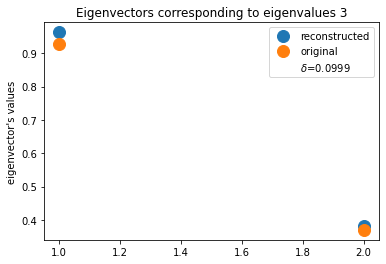

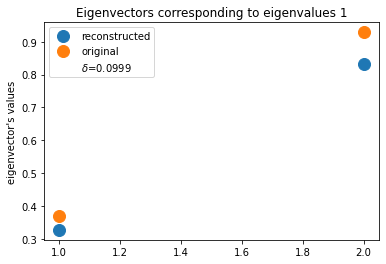

In [329]:
eigenvectors_benchmarking(example_matrix,eigenvectors,delta=delta)

## 1st matrix_example

In [501]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.4063074844837685,
  '0101': -0.4947759382402847,
  '1001': -0.48985675123506794,
  '1101': 0.5917358889406178},
 {'0011': 0.5898840122966107,
  '0111': 0.49452547412185405,
  '1011': 0.4915537016695547,
  '1111': 0.4072546695329175},
 (array([3., 1.]),
  array([[ 0.76746056, -0.64109616],
         [ 0.64109616,  0.76746056]])))

$$\left|01\right\rangle(0.4063|00\rangle-0.4947|01\rangle-0.4898|10\rangle+0.5917|11\rangle) =$$

$$\left|01\right\rangle(0.4063|0\rangle(|0\rangle-1.21|1\rangle)-0.4898|1\rangle(|0\rangle-x|1\rangle)) =$$

$$\left|01\right\rangle((0.4063|0\rangle-0.4898|1\rangle)(|0\rangle-x|1\rangle)) =$$

$$\left|01\right\rangle(0.4063(|0\rangle-y|1\rangle)(|0\rangle-x|1\rangle)) =>$$

$$\sqrt{0.5917}=0.7692$$

$$0.7692*\approx0.8*\text{sign}\left|1\right\rangle=-0.6153$$




$$\left|11\right\rangle(0.5898|00\rangle+0.4945|01\rangle+0.4915|10\rangle+0.4072|11\rangle) =$$

$$\left|11\right\rangle(0.5898|0\rangle(|0\rangle+0.83|1\rangle)+0.4915|1\rangle(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle((0.5898|0\rangle+0.4915|1\rangle)(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle(0.5898(|0\rangle+0.83|1\rangle)(|0\rangle+0.83|1\rangle)) =>$$

$$\sqrt{0.5898}=0.7679$$

$$0.7679*\approx0.8*\text{sign}\left|0\right\rangle=0.6143$$




## 2nd matrix_example

$$\left|01\right\rangle(0.1272|00\rangle-0.3143|01\rangle-0.3203|10\rangle+0.8845|11\rangle) =$$

$$\left|01\right\rangle(0.3143|0\rangle(0.40|0\rangle-|1\rangle)-0.8845|1\rangle(0.36|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle((0.3143|0\rangle-0.8845|1\rangle)(0.4|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle(0.8845(0.36|0\rangle-|1\rangle)(0.4|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.8845}=0.9404$$

$$0.9404*\approx0.4*\text{sign}\left|1\right\rangle=-0.3761$$




## 3d matrix_example

In [643]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.36710092124099825,
  '0101': 0.6614992335357107,
  '1001': 0.3149078628268718,
  '1101': 0.5731393509308969},
 {'0011': 0.8721533545579773,
  '0111': -0.4889160360072559,
  '1011': 0.013630169512202875,
  '1111': -0.011128986804178979},
 (array([3., 1.]),
  array([[ 0.87370608,  0.4864542 ],
         [-0.4864542 ,  0.87370608]])))

$$\left|01\right\rangle(0.3671|00\rangle+0.6614|01\rangle+0.3149|10\rangle+0.5731|11\rangle) =$$

$$\left|01\right\rangle(0.6614|0\rangle(0.55|0\rangle+|1\rangle)+0.5731|1\rangle(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle((0.6614|0\rangle+0.5731|1\rangle)(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle(0.6614(|0\rangle+\approx0.8|1\rangle)(0.55|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.6614}=\approx0.81$$

$$0.81*\approx0.55*\text{sign}\left|1\right\rangle=\approx0.44$$




$$\left|11\right\rangle(0.8721|00\rangle-0.4889|01\rangle+0.0136|10\rangle-0.0111|11\rangle) =$$

$$\left|11\right\rangle(0.8721|0\rangle(|0\rangle-\approx0.5|1\rangle)+0.0136|1\rangle(|0\rangle-\approx0.8|1\rangle)) =$$

$$\left|11\right\rangle((0.8721|0\rangle+0.0136|1\rangle)(|0\rangle-\approx0.5|1\rangle)) =$$

$$\left|11\right\rangle(0.8721(|0\rangle+0.0155|1\rangle)(|0\rangle-0.5|1\rangle)) =>$$

$$\sqrt{0.8721}=\approx0.93$$

$$0.93*\approx0.5*\text{sign}\left|0\right\rangle=\approx0.44$$




## 4th matrix_example

In [672]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.06844207564752064,
  '0101': -0.2434477406836873,
  '1001': -0.26237207143606917,
  '1101': 0.9312409870529826},
 {'0011': 0.9317470599478411,
  '0111': 0.2529050552183149,
  '1011': 0.251498062074687,
  '1111': 0.06808211289503242},
 (array([3., 1.]),
  array([[ 0.96521162, -0.26146994],
         [ 0.26146994,  0.96521162]])))

$$\left|11\right\rangle(0.93|00\rangle+0.25|01\rangle+0.25|10\rangle+0.068|11\rangle) =$$

$$\left|11\right\rangle(0.93|0\rangle(|0\rangle+\approx0.26|1\rangle)+0.25|1\rangle(|0\rangle+0.2|1\rangle)) =$$

$$\left|11\right\rangle((0.93|0\rangle+0.25|1\rangle)(|0\rangle+\approx0.2|1\rangle)) =$$

$$\left|11\right\rangle(0.93(|0\rangle+0.2|1\rangle)(|0\rangle+0.2|1\rangle)) =>$$

$$\sqrt{0.93}=\approx0.96$$

$$0.96*\approx0.2*\text{sign}\left|0\right\rangle=\approx0.25$$


